In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [4]:
milk_data_OG = pd.read_csv('../Data/TheData.csv')
milk_data_OG['DateTime'] = pd.to_datetime(milk_data_OG['DateTime'], errors='coerce')
milk_data_OG['StartTime'] = pd.to_datetime(milk_data_OG['StartTime'], format='%H:%M:%S', errors='coerce').dt.time
milk_data_OG['StartDate'] = pd.to_datetime(milk_data_OG['StartDate'], errors='coerce')
milk_data_OG.head(3)

,FarmName_Pseudo,SE_Number,AnimalNumber,StartDate,StartTime,LactationNumber,DaysInMilk,TotalYield,DateTime,BreedName,Temperature,Relative Humidity,Precipitation,THI_adj,HW,cum_HW
0,a624fb9a,SE-a624fb9a-1425,1425,2022-04-14,17:53:00,1,42.0,7.68,2022-04-14 17:53:00,01 SRB,4.2,86.8,0.0,-836.25624,0,0.0
1,a624fb9a,SE-a624fb9a-1212,1212,2022-04-14,17:45:00,5,192.0,9.58,2022-04-14 17:45:00,02 SLB,4.2,86.8,0.0,-836.25624,0,0.0
2,a624fb9a,SE-a624fb9a-1299,1299,2022-04-14,17:54:00,3,138.0,10.94,2022-04-14 17:54:00,01 SRB,4.2,86.8,0.0,-836.25624,0,0.0


In [8]:
milk_data = milk_data_OG.copy()
milk_data['CategoricalTime'] = milk_data['StartDate'].dt.month
milk_data['Farm_CategoricalTime'] = pd.Categorical(milk_data['FarmName_Pseudo'] + '_' + milk_data['CategoricalTime'].astype(str))
DATA = pd.concat([milk_data[['DateTime', 'StartDate', 'SE_Number','FarmName_Pseudo','TotalYield', 'HW', 'cum_HW', 'DaysInMilk', 'LactationNumber','BreedName', 'Farm_CategoricalTime', 'Temperature', 'Relative Humidity', 'THI_adj']]], axis=1)

### Select farm by adjusting below variable name
#### **Possible farms**
> - a624fb9a *
> - ab18b151
> - 540275a1
> - f454e660 *
> - afdd9a78
> - 5b581702
> - 5f7f33d6
> - ad0a39f5
> - 5c06d92d


In [9]:
farm_pseudo  = 'f454e660' # <---------- Adjust here
## 

data = DATA[DATA['FarmName_Pseudo'] == farm_pseudo] # Get the farm data
print(f"The dataframe for Farm {farm_pseudo} has {data.shape[0]} entries and {data.shape[1]} columns")

The dataframe for Farm f454e660 has 192691 entries and 14 columns


### Get daily records for chosen farm

Here we calculate the daily yield for each cow. We also get the daily mean temperature as well as the daily max temperature etc.

In [16]:
agg_functions = {
    'TotalYield': 'sum', # Daily sum of all the yields. Can be replaced with 'mean' to get daily mean instead
    'HW': 'first', # Since the HW indicator will be the same for all instances of the same day (given the same farm), we save the 'first'
    'cum_HW': 'first', # Same as for 'HW'
    'DaysInMilk': 'first', # Same as for 'HW'
    'LactationNumber': 'first', # Same as for 'HW'
    'BreedName': 'first', # It will be the same cow, so we save first instance of 'BreedName'
    'Temperature': ['mean', 'max'], #Save both the daily Max temperature as well as daily mean temperature
    'Relative Humidity': 'mean', # Save daily mean humidity
    'THI_adj': 'mean' # save daily mean THI-adjusted
}

daily_data = data.groupby(['SE_Number', 'StartDate']).agg(agg_functions).reset_index() #Group by animal (SE_Number) and day (StartDate)

daily_data.columns = [' '.join(col).strip() if 'first' not in col[1] else col[0] for col in daily_data.columns.values] # Remove the weird 'first' prefixes from the column names

# rename the columns to approiate prefixes
daily_data = daily_data.rename(columns={
    'TotalYield sum': 'DailyTotalYield',
    'DaysInMilk first': 'DaysInMilk',
    'Temperature mean': 'MeanTemperature',
    'Temperature max': 'MaxTemperature',
    'Relativ Humidity mean': 'MeanRelHumidity',
    'THI_adj mean': 'MeanTHI_adj'
})

### Normalize based on Wood's Lactation Curve

In [17]:
# Define the Wood's Lactation Curve function
def woods_lactation_curve(dim, a, b, c):
    dim = np.array(dim, dtype=float)
    return a * dim**b * np.exp(-c * dim)

# Function to fit the Wood's Lactation Curve to the dataset
def fit_woods_lactation_curve(dataset):
    # Initialize the 'ExpectedYield' column to NaN
    dataset['ExpectedYield'] = np.nan
    
    # Group the dataset by 'SE_Number' and fit the curve for each cow
    for animal_number, group in tqdm(dataset.groupby('SE_Number'), unit= " Cows"):
        # Prepare the data for fitting
        x_data = group['DaysInMilk']
        y_data = group['DailyTotalYield']
        
        # Fit the model
        try:
            # Initial parameter guesses
            initial_guesses = [max(y_data), 0.4, 0.0001]
            # Bounds on the parameters to prevent overflow
            bounds = ([0, 0, 0], [np.inf, 1, 0.1])
            popt, pcov = curve_fit(
                woods_lactation_curve, x_data, y_data,
                p0=initial_guesses, bounds=bounds, maxfev=10000
            )
            
            # Predict the expected yield using the fitted model
            group['ExpectedYield'] = woods_lactation_curve(group['DaysInMilk'], *popt)
            
            # Normalize the DailyTotalYield
            group['NormalizedDailyTotalYield'] = group['DailyTotalYield'] / group['ExpectedYield']
            
            # Update the dataset with the fitted data
            dataset.loc[group.index, 'ExpectedYield'] = group['ExpectedYield']
            dataset.loc[group.index, 'NormalizedDailyTotalYield'] = group['NormalizedDailyTotalYield']
            
        except RuntimeError as e:
            print(f"Curve fit failed for cow {animal_number}: {e}")
    
    # Fill any NaN values in the newly created columns with 0
    dataset['ExpectedYield'].fillna(0, inplace=True)
    dataset['NormalizedDailyTotalYield'].fillna(0, inplace=True)
    
    return dataset

daily_data = fit_woods_lactation_curve(daily_data)
print(f"The daily records dataframe for farm {farm_pseudo} has {daily_data.shape[0]} entries and {daily_data.shape[1]} columns")
daily_data.head(3)

  0%|          | 0/220 [00:00<?, ? Cows/s]c:\Users\axele\.conda\envs\Doris\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 99%|█████████▊| 217/220 [00:12<00:00, 25.34 Cows/s]c:\Users\axele\.conda\envs\Doris\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
100%|██████████| 220/220 [00:12<00:00, 17.87 Cows/s]

The daily records dataframe for farm f454e660 has 84007 entries and 14 columns


,SE_Number,StartDate,DailyTotalYield,HW,cum_HW,DaysInMilk,LactationNumber,BreedName,MeanTemperature,MaxTemperature,Relative Humidity mean,MeanTHI_adj,ExpectedYield,NormalizedDailyTotalYield
0,SE-7fd04cd3-679,2022-01-01,12.93,0,0.0,339.0,4,04 SJB,1.2,1.2,81.7,-1031.67028,13.574447,0.952525
1,SE-7fd04cd3-679,2022-01-02,13.72,0,0.0,340.0,4,04 SJB,4.9,4.9,99.0,-892.58760,13.614490,1.007750
2,SE-7fd04cd3-679,2022-01-03,14.19,0,0.0,341.0,4,04 SJB,4.7,4.7,94.8,-874.35096,13.654533,1.039215


### Visualisation

Following is to visualize difference between **daily yield** between **breeds** and wheter or not it was during a **heatwave** `HW`

---

`HW = 0` -- No heatwave

`HW = 1` -- During a heatwave or heatwave at most 1 week ago

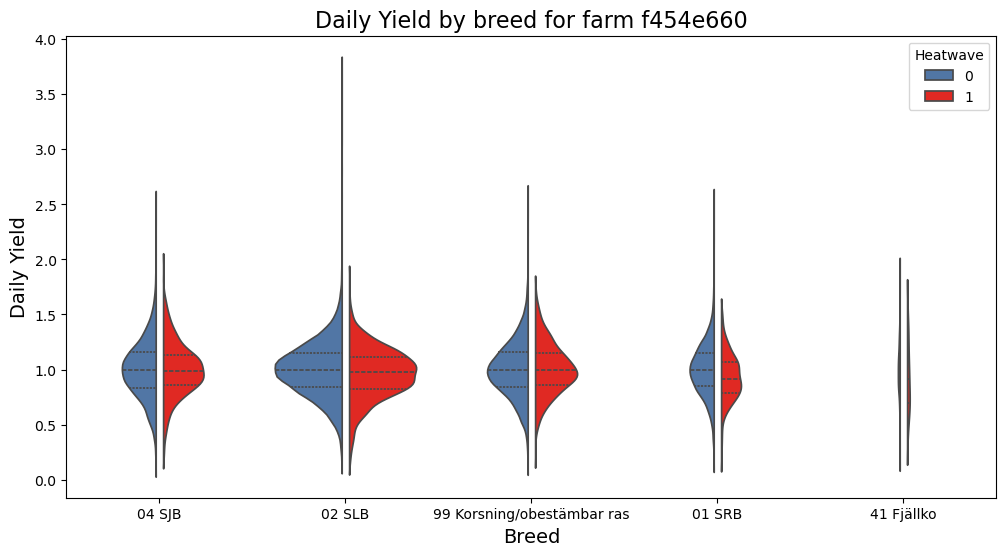

In [18]:
# plot violinplot
plt.figure(figsize=(12, 6))

colors = ["#4374B3", "#FF0B04"]
sns.set_palette(sns.color_palette(colors))
sns.violinplot(x='BreedName', y='NormalizedDailyTotalYield', hue= 'HW', data=daily_data, split=True, inner="quart", gap=.1, density_norm="count")
plt.xlabel('Breed', fontsize=14)
plt.ylabel('Normalized Daily Yield', fontsize=14)
plt.title(f'Daily Yield by breed for farm {farm_pseudo}', fontsize=16)
plt.legend(title='Heatwave', loc='upper right')
plt.show()